In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp


# Part 1:
## Organize and configure data for this notebook

In [2]:
# financial data
DJI_df = pd.read_csv('^DJI.csv')[['Date', 'Adj Close']]
TNX_df = pd.read_csv('^TNX.csv')[['Date', 'Adj Close']]
unemployment_df = pd.read_csv('unemployment.csv')

# educational data
gr_en_df = pd.read_csv('graduationAndEnrollment.csv', index_col=0)
rank_df = pd.read_csv('schools_ranking.csv', index_col=0).drop(['name'], axis=1)
sfa_df = pd.read_csv('student_financial_aid.csv', index_col=0)
uni_finance_df = pd.read_csv('university_financial.csv', index_col=0)

usa_gdf = gpd.read_file("gz_2010_us_040_00_20m.json")
uni_gdf = gpd.read_file("uni_geo_location.geojson")

edu_df = pd.merge(gr_en_df,rank_df, left_on='UNITID', right_on='UNITID', how='left')
# add rank 181, if not included in the top 180 ranking
edu_df['Rank'] = edu_df['Rank'].fillna(181)
edu_df = pd.merge(edu_df,sfa_df.drop('TYPE', axis=1), left_on='UNITID', right_on='UNITID', how='inner')
edu_df = pd.merge(edu_df,uni_finance_df.drop('TYPE', axis=1), left_on='UNITID', right_on='UNITID', how='inner')

edu_change_df = pd.read_csv('percentage_change_all_vars.csv', index_col=0)



In [3]:
# make graduation and enrollment columns follow same nameing 
# convention as other columns
cols = edu_df.columns.tolist()
for i in range(len(cols)):
    if cols[i][0] == 'g':
        endYear = cols[i][-2:]
        beginingYear = str(int(endYear)-1).zfill(2)
        cols[i] = beginingYear + endYear + '_' + 'GR'
    elif cols[i][0] == 'e':
        endYear = cols[i][-2:]
        beginingYear = str(int(endYear)-1).zfill(2)
        cols[i] = beginingYear + endYear + '_' + 'EN'
edu_df.columns = cols


In [4]:
#Drop rows with missing data
edu_df = edu_df.dropna(how='any') 
edu_change_df = edu_change_df.dropna(how='any') 

In [5]:
list_all_uni = pd.merge(edu_df[['UNITID']], edu_change_df[['UNITID']], left_on='UNITID', right_on='UNITID', how='inner' )

In [6]:
edu_df = pd.merge(edu_df,list_all_uni, left_on='UNITID', right_on='UNITID', how='inner')
edu_change_df = pd.merge(edu_change_df,list_all_uni, left_on='UNITID', right_on='UNITID', how='inner')


# ----------------------------------------------------

# Part2:
## initial exploritory analysis

datasets available:

edu_df

edu_change_df

uni_gdf

usa_gdf

DJI_df

TNX_df

unemployment_df

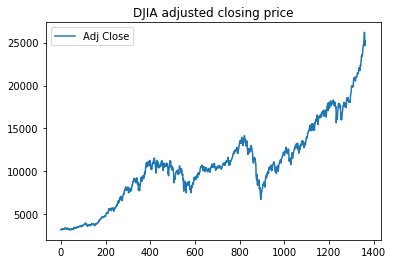

In [7]:
DJI_df.plot(title="DJIA adjusted closing price")
plt.show()

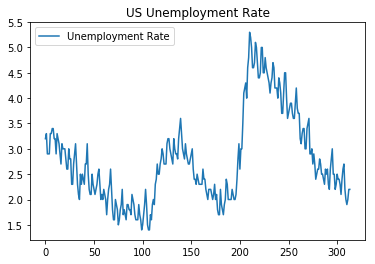

In [8]:
unemployment_df.plot(title="US Unemployment Rate")
plt.legend(['Unemployment Rate'])
plt.show()

/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


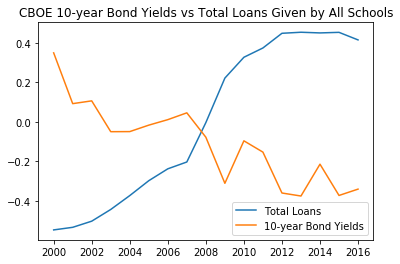

In [21]:
#Normalized aggregate sum of all students loans (blue) 
#normalized CBOE 10-year bond yields (orange)
TNX_normalized_df = TNX_df.copy()
adjClose  = TNX_normalized_df['Adj Close'].values
closeMin  = np.min(adjClose)
closeMax  = np.max(adjClose)
closeMean = np.mean(adjClose)
TNX_normalized_df['Adj Close'] = TNX_normalized_df['Adj Close'].apply(lambda x: (x-closeMean)/(closeMax-closeMin))
TNX_normalized_df.columns = ['Date', "10-year Bond Yields"]

totalLoans = edu_df[['9900_LOAN_A','0001_LOAN_A','0102_LOAN_A','0203_LOAN_A','0304_LOAN_A','0405_LOAN_A','0506_LOAN_A','0607_LOAN_A','0708_LOAN_A','0809_LOAN_A','0910_LOAN_A','1011_LOAN_A','1112_LOAN_A','1213_LOAN_A','1314_LOAN_A','1415_LOAN_A','1516_LOAN_A',
                     '9900_LOAN_N','0001_LOAN_N','0102_LOAN_N','0203_LOAN_N','0304_LOAN_N','0405_LOAN_N','0506_LOAN_N','0607_LOAN_N','0708_LOAN_N','0809_LOAN_N','0910_LOAN_N','1011_LOAN_N','1112_LOAN_N','1213_LOAN_N','1314_LOAN_N','1415_LOAN_N','1516_LOAN_N']]

for col1 in totalLoans.columns:
    for col2 in totalLoans.columns:
        if col1[:10] == col2[:10] and col1[-1]=='A' and col2[-1] == 'N':
            totalLoans[col1[:10] + 'T'] = totalLoans[col1] * totalLoans[col2]
            totalLoans = totalLoans.drop( [col1, col2], axis=1)
            
totalLoans = totalLoans.sum(axis=0).tolist()
dates = ['2000-01-05', '2001-01-03', '2002-01-02', '2003-01-01', '2004-01-07', '2005-01-05', 
         '2006-01-04', '2007-01-03', '2008-01-02', '2009-01-07', '2010-01-06', '2011-01-05', 
         '2012-01-04', '2013-01-02', '2014-01-01', '2015-01-07', '2016-01-06']

totalLoans_df = pd.DataFrame()
totalLoans_df['Date'] = dates
totalLoans_df['Total Loans'] = totalLoans

totalLoans  = totalLoans_df['Total Loans'].values
loanMin  = np.min(totalLoans)
loanMax  = np.max(totalLoans)
loanMean = np.mean(totalLoans)
totalLoans_df['Total Loans'] = totalLoans_df['Total Loans'].apply(lambda x: (x-loanMean)/(loanMax-loanMin))

plot_df = pd.merge(totalLoans_df, TNX_normalized_df, left_on='Date', right_on='Date', how='inner')
plt.figure(figsize=(5,5))
plot_df.plot(title='CBOE 10-year Bond Yields vs Total Loans Given by All Schools')
plt.xticks(range(0,17,2),list(range(2000,2017,2)))
plt.show()

In [10]:
print('Correlation between CBOE 10-year Bond Yields and Total Loans Given by All Schools:', plot_df['Total Loans'].corr(plot_df['10-year Bond Yields']))

Correlation between CBOE 10-year Bond Yields and Total Loans Given by All Schools: -0.8734087678746737


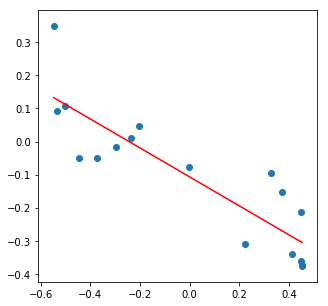

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(plot_df['Total Loans'], plot_df['10-year Bond Yields'])
plt.plot(np.unique(plot_df['Total Loans']), np.poly1d(np.polyfit(plot_df['Total Loans'], plot_df['10-year Bond Yields'], 1))(np.unique(plot_df['Total Loans'])), c='red' )
plt.show()

In [12]:
bestFitLine = np.polyfit(plot_df['Total Loans'], plot_df['10-year Bond Yields'], 1)
print("Best line fit to normalized Total Loans and 10-year Bond Yields: y = " + str(round(bestFitLine[1], 3)) + str(round(bestFitLine[0], 3)) + 'x')

Best line fit to normalized Total Loans and 10-year Bond Yields: y = -0.107-0.437x


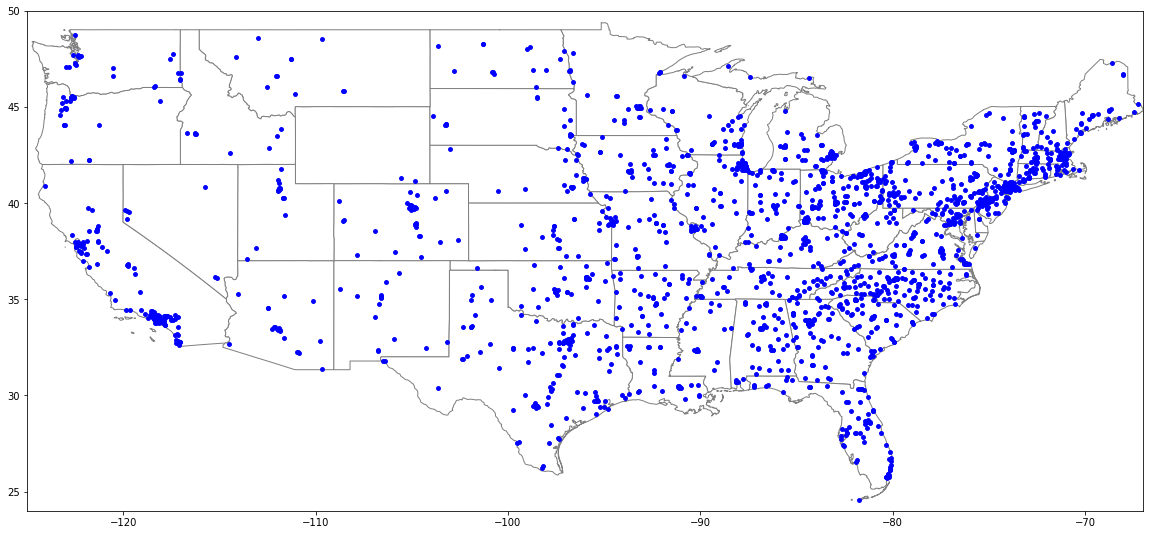

In [22]:
plt.rcParams['figure.figsize'] = (20, 20)



USA_base = usa_gdf.plot(color='white', edgecolor='grey')
USA_base.set_xlim([-125.00, -67.00])
USA_base.set_ylim([24.00, 50.00])

uni_gdf.plot(ax=USA_base, marker='o', color='blue', markersize=15);

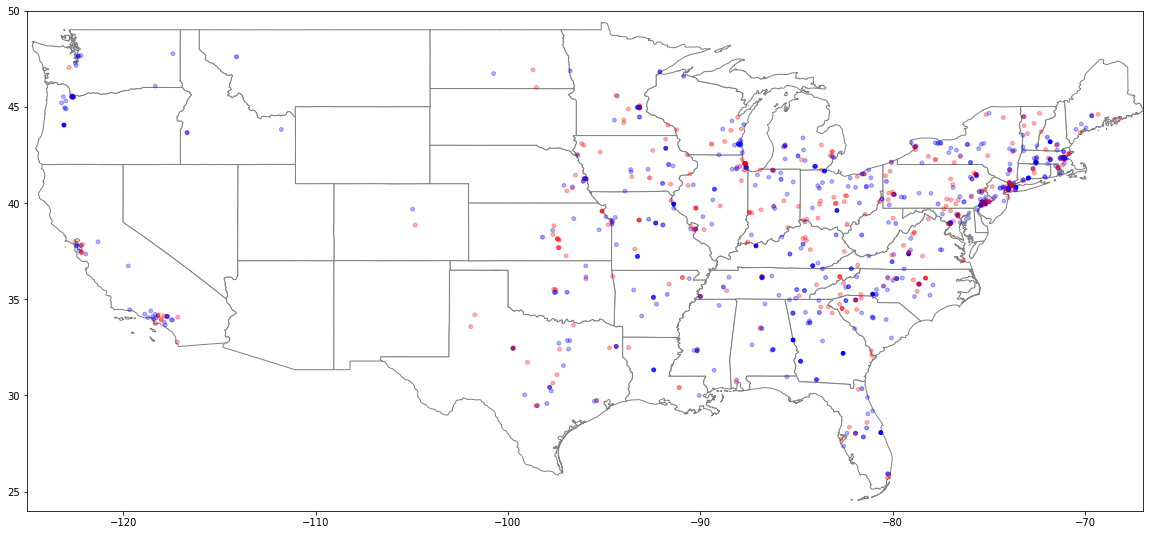

In [27]:
plt.rcParams['figure.figsize'] = (20, 20)


edu_change_df_not_for_profit = edu_change_df.loc[(edu_change_df['TYPE'] == 'not-for-profit')]
uni_not_for_profit_df = pd.merge(uni_gdf,edu_change_df_not_for_profit[['UNITID','0809_EN']], left_on='UNITID', right_on='UNITID', how='inner')

colors = uni_not_for_profit_df["0809_EN"].tolist()
colors = [(0.0, 0.0, 1, max(0.3,min(1,x/20)) ) if x > 0.1 else ( (1, 0.0, 0.0, max(0.3, min(1,abs(x/20)))) if x < 0 else (0,0,0,0)) for x in colors]

USA_base = usa_gdf.plot(color='white', edgecolor='grey')
USA_base.set_xlim([-125.00, -67.00])
USA_base.set_ylim([24.00, 50.00])

uni_not_for_profit_df.plot(ax=USA_base, marker='o', c=colors, markersize=15);

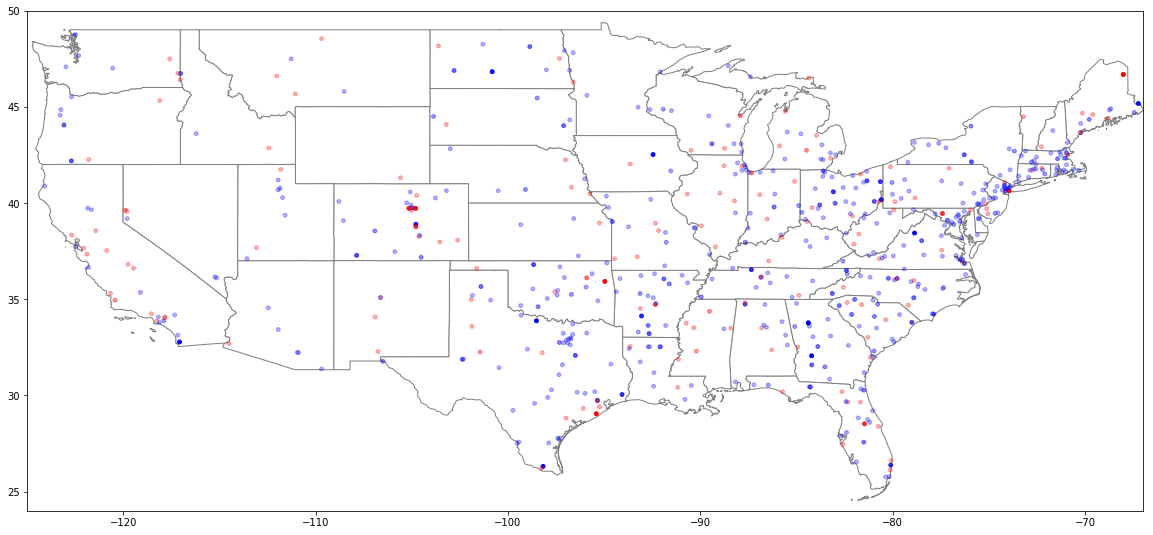

In [29]:
plt.rcParams['figure.figsize'] = (20, 20)


edu_change_df_public = edu_change_df.loc[(edu_change_df['TYPE'] == 'public')]
uni_public_df = pd.merge(uni_gdf,edu_change_df_public[['UNITID','0809_EN']], left_on='UNITID', right_on='UNITID', how='inner')

colors = edu_change_df_public["0809_EN"].tolist()
colors = [(0.0, 0.0, 1, max(0.3,min(1,x/20)) ) if x > 0.1 else ( (1, 0.0, 0.0, max(0.3, min(1,abs(x/20)))) if x < 0 else (0,0,0,0)) for x in colors]

USA_base = usa_gdf.plot(color='white', edgecolor='grey')
USA_base.set_xlim([-125.00, -67.00])
USA_base.set_ylim([24.00, 50.00])

uni_public_df.plot(ax=USA_base, marker='o', c=colors, markersize=15);